Importing Libraries

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import drive
from tensorflow.keras import layers, Model


Data Loader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LR images shape: (10000, 1, 75, 75)
HR images shape: (10000, 1, 150, 150)
Number of LR images: 10000
Number of HR images: 10000
Shape of one LR image: (1, 75, 75)
Shape of one HR image: (1, 150, 150)
Sample entry [[[0.01615789 0.01594497 0.01057685 ... 0.01319846 0.00957293 0.01057328]
  [0.00752465 0.0165968  0.00791955 ... 0.00631138 0.01182699 0.01349821]
  [0.01239913 0.00841438 0.01346253 ... 0.01260134 0.01169615 0.01562262]
  ...
  [0.0098703  0.00553465 0.01051619 ... 0.01284162 0.01085876 0.01160337]
  [0.01119062 0.01489942 0.01275717 ... 0.01027234 0.01060302 0.01406083]
  [0.00916613 0.01467936 0.0093957  ... 0.01376465 0.01052213 0.01082307]]]


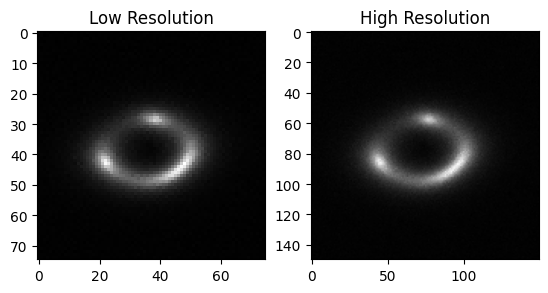

In [21]:
drive.mount('/content/drive')
'''
# Paths to LR and HR folders
lr_path = '/content/drive/My Drive/Lensing Resources/Dataset/LR'
hr_path = '/content/drive/My Drive/Lensing Resources/Dataset/HR'


# Function to load images from a folder and convert them to NumPy arrays
def load_images_to_numpy(folder_path):
    images = []
    for filename in os.listdir(folder_path):
          img_path = os.path.join(folder_path, filename)
          img_array = np.load(img_path)
          images.append(img_array)
    return np.array(images)

lr_images = load_images_to_numpy(lr_path)
hr_images = load_images_to_numpy(hr_path)
'''
#This takes too much time, trying to load zip and extract here. Should be faster.

import zipfile

zip_path = '/content/drive/My Drive/Lensing Resources/3a_Dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/3a_Dataset')

# Load all .npy files from the extracted folder
lr_path = '/content/3a_Dataset/Dataset/LR'
hr_path = '/content/3a_Dataset/Dataset/HR'

lr_files = sorted([os.path.join(lr_path, f) for f in os.listdir(lr_path) if f.endswith('.npy')])
hr_files = sorted([os.path.join(hr_path, f) for f in os.listdir(hr_path) if f.endswith('.npy')])

lr_images = np.array([np.load(f) for f in lr_files])
hr_images = np.array([np.load(f) for f in hr_files])



# Just verifying stuff
print("LR images shape:", lr_images.shape)
print("HR images shape:", hr_images.shape)
print(f"Number of LR images: {len(lr_images)}")
print(f"Number of HR images: {len(hr_images)}")
print(f"Shape of one LR image: {lr_images[0].shape}")
print(f"Shape of one HR image: {hr_images[0].shape}")
print("Sample entry", lr_images[0])
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Low Resolution')
plt.imshow(lr_images[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('High Resolution')
plt.imshow(hr_images[0].squeeze(), cmap='gray')

Defining RCAN

In [22]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Layer
from tensorflow.keras.models import Model
# Define Channel Attention Module
def channel_attention(input_feature, ratio=16):
    channels = input_feature.shape[-1]
    ga_pool = GlobalAveragePooling2D()(input_feature)
    ga_pool = Reshape((1, 1, channels))(ga_pool)
    dense1 = Dense(channels // ratio, activation='relu')(ga_pool)
    dense2 = Dense(channels, activation='sigmoid')(dense1)
    return dense2

# Define Residual Channel Attention Block (RCAB)
def rcab(inputs, num_filters=64, ratio=16):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.activations.relu(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    ca = channel_attention(x, ratio)
    x = Multiply()([x, ca])
    x = Add()([x, inputs])
    return x

# Define Residual Group
def residual_group(inputs, num_rcab=5, num_filters=64, ratio=16):
    x = inputs
    for _ in range(num_rcab):
        x = rcab(x, num_filters, ratio)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, inputs])
    return x

# Custom Layer for Depth-to-Space (PixelShuffle)
class DepthToSpace(Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(DepthToSpace, self).get_config()
        config.update({'scale': self.scale})
        return config

# Build RCAN Model
def build_rcan(input_shape=(75, 75, 1), scale=2, num_rg=5, num_rcab=5, num_filters=64, ratio=16):
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    initial = x

    # Residual Groups
    for _ in range(num_rg):
        x = residual_group(x, num_rcab, num_filters, ratio)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, initial])

    # Upsampling
    x = Conv2D(num_filters * (scale ** 2), 3, padding='same')(x)
    x = DepthToSpace(scale)(x)  # Use custom layer for depth_to_space
    x = Conv2D(1, 3, padding='same', activation='relu')(x)

    return Model(inputs, x)


# Create the RCAN Model
model = build_rcan()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 75, 75, 64)     │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_50 (ReLU)           │ (None, 75, 75, 64)     │              0 │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ re_lu_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_120[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_50 (Reshape)      │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 1, 1, 4)        │            260 │ reshape_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 1, 1, 64)       │            320 │ dense_100[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_50 (Multiply)    │ (None, 75, 75, 64)     │              0 │ conv2d_120[0][0],      │
│                           │                        │                │ dense_101[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_62 (Add)              │ (None, 75, 75, 64)     │              0 │ multiply_50[0][0],     │
│                           │                        │                │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ add_62[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_51 (ReLU)           │ (None, 75, 75, 64)     │              0 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ re_lu_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_122[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_51 (Reshape)      │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_102 (Dense)         │ (None, 1, 1, 4)        │            260 │ reshape_51[0][0]       │
├──────────────────────

 Total params: 2,231,397 (8.51 MB)

 Trainable params: 2,231,397 (8.51 MB)

 Non-trainable params: 0 (0.00 B)

Checkpointing

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/Lensing Resources/3a_checkpointing.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model
    mode='min',
    verbose=1
)

Compile Model

In [24]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0)  # Clip gradients to [-1.0, 1.0]
#model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mse' , metrics = ['mae'])


Process Data

(10000, 1, 75, 75)
(10000, 1, 150, 150)
(10000, 75, 75, 1)
(10000, 150, 150, 1)


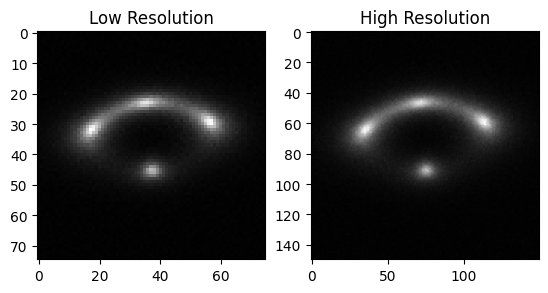

In [25]:
# Reshape LR and HR images to add channel dimension (if not already present)
print(lr_images.shape)
print(hr_images.shape)
lr_images = lr_images.reshape(-1, 75, 75, 1)
hr_images = hr_images.reshape(-1, 150, 150, 1)
print(lr_images.shape)
print(hr_images.shape)
# Normalize pixel values to [0, 1] (if not already normalized)
#lr_images = lr_images.astype('float32') / 255.0
#hr_images = hr_images.astype('float32') / 255.0

# Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)

# Create TensorFlow Datasets, because some pipeline issue
def create_dataset(lr, hr, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((lr, hr))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)


#print(model.weights)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Low Resolution')
plt.imshow(X_train[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('High Resolution')
plt.imshow(y_train[0].squeeze(), cmap='gray')

Train Model

In [26]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=60,
    callbacks=[checkpoint_callback]
)


Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.0029 - mae: 0.0217
Epoch 1: val_loss improved from inf to 0.00025, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 415ms/step - loss: 0.0029 - mae: 0.0217 - val_loss: 2.4694e-04 - val_mae: 0.0095
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 2.1739e-04 - mae: 0.0089
Epoch 2: val_loss improved from 0.00025 to 0.00016, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 402ms/step - loss: 2.1730e-04 - mae: 0.0089 - val_loss: 1.5768e-04 - val_mae: 0.0077
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 1.4792e-04 - mae: 0.0075
Epoch 3: val_loss improved from 0.00016 to 0.00012, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 402ms/step - loss: 1.4789e-04 - mae: 0.0075 - val_loss: 1.2425e-04 - val_mae: 0.

In [27]:
model.weights

[<Variable path=conv2d_118/kernel, shape=(3, 3, 1, 64), dtype=float32, value=[[[[ 0.06483404  0.01562036  0.06711433 -0.00318523  0.09345653
     -0.01931052 -0.06203691 -0.09465972  0.07201489 -0.00447463
      0.0894124   0.0201675   0.07085544  0.02772383 -0.00644617
      0.07496704  0.03178702 -0.03430078  0.03157424 -0.05093599
     -0.03809354  0.09936807 -0.04507505 -0.00666857 -0.0718485
      0.08430006  0.03726572  0.0410211   0.07528041  0.07751202
     -0.05365195  0.02660548 -0.05792242  0.07321237  0.01950658
      0.05114213 -0.06849571  0.09244147 -0.09476204  0.00707688
     -0.01611888  0.01357171  0.00195875 -0.09862546 -0.08229684
      0.00752319  0.08401621  0.04245678 -0.00549574  0.03387762
     -0.09440916 -0.07889621 -0.00899116 -0.01745812  0.0476868
      0.00186817  0.03560337 -0.05775125 -0.07556158  0.09138107
      0.09018558 -0.03929675  0.08400484  0.05470068]]
 
   [[-0.01160481 -0.02882488  0.01768412  0.08131072  0.07494333
      0.05745481 -0.0051

Evaluating Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.9870e-05 - mae: 0.0049
Validation Loss: 5.9831469116033986e-05
Validation MAE: 0.004935797303915024
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step


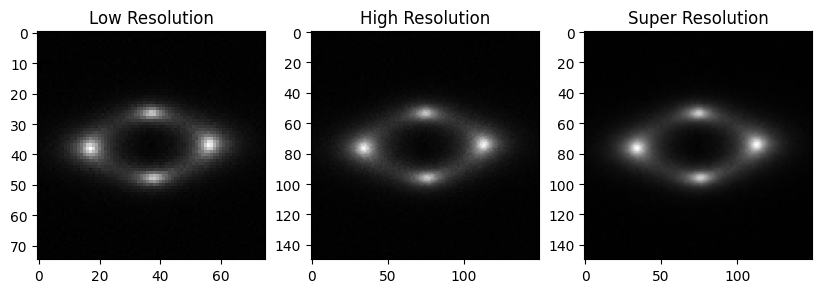

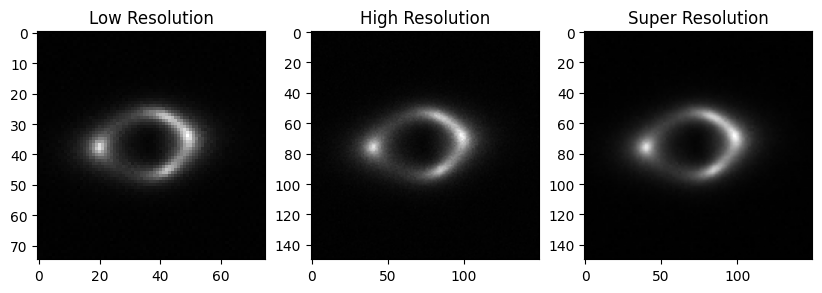

[[[0.01123463]
  [0.01020518]
  [0.01124456]
  ...
  [0.01124754]
  [0.01095238]
  [0.01098656]]

 [[0.01093594]
  [0.01102368]
  [0.0094658 ]
  ...
  [0.01182346]
  [0.01131367]
  [0.00890267]]

 [[0.01050957]
  [0.00919103]
  [0.00789236]
  ...
  [0.0101022 ]
  [0.01016341]
  [0.00992038]]

 ...

 [[0.00939805]
  [0.00934058]
  [0.0115656 ]
  ...
  [0.01146719]
  [0.00895597]
  [0.01240555]]

 [[0.00986663]
  [0.0103153 ]
  [0.01039712]
  ...
  [0.01294906]
  [0.0103789 ]
  [0.00965037]]

 [[0.00968012]
  [0.0107755 ]
  [0.01183726]
  ...
  [0.01085713]
  [0.00828637]
  [0.0089797 ]]]


In [28]:
# Evaluate the model
loss, mae = model.evaluate(X_val, y_val, verbose=1)
#loss = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation MAE: {mae}")

# Visualize some predictions
import matplotlib.pyplot as plt

def plot_results(lr, hr, sr, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution')
    plt.imshow(lr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('High Resolution')
    plt.imshow(hr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Super Resolution')
    plt.imshow(sr[index].squeeze(), cmap='gray')
    plt.show()

# Generate super-resolution images
sr_images = model.predict(X_val)

# Plot some results
plot_results(X_val, y_val, sr_images, index=0)
plot_results(X_val, y_val, sr_images, index=1)
print(sr_images[0])

Saving the model

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class DepthToSpace(Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(DepthToSpace, self).get_config()
        config.update({'scale': self.scale})
        return config

loaded_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Lensing Resources/3a_checkpointing.keras',
    custom_objects={'DepthToSpace': DepthToSpace}
)

# Verify the loaded model
loaded_model.summary()

# Evaluate the loaded model
loss, mae = loaded_model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation MAE: {mae}")

final_model_path = '/content/drive/My Drive/Lensing Resources/3a_best_checkpoint.keras'
loaded_model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 75, 75, 64)     │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_50 (ReLU)           │ (None, 75, 75, 64)     │              0 │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ re_lu_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_120[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_50 (Reshape)      │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 1, 1, 4)        │            260 │ reshape_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 1, 1, 64)       │            320 │ dense_100[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_50 (Multiply)    │ (None, 75, 75, 64)     │              0 │ conv2d_120[0][0],      │
│                           │                        │                │ dense_101[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_62 (Add)              │ (None, 75, 75, 64)     │              0 │ multiply_50[0][0],     │
│                           │                        │                │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ add_62[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_51 (ReLU)           │ (None, 75, 75, 64)     │              0 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 75, 75, 64)     │         36,928 │ re_lu_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_122[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_51 (Reshape)      │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_102 (Dense)         │ (None, 1, 1, 4)        │            260 │ reshape_51[0][0]       │
├──────────────────────

 Total params: 6,694,193 (25.54 MB)

 Trainable params: 2,231,397 (8.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,462,796 (17.02 MB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 5.9865e-05 - mae: 0.0049
Validation Loss: 5.982772199786268e-05
Validation MAE: 0.004935463424772024
Final model saved to /content/drive/My Drive/Lensing Resources/3a_best_checkpoint.keras
